In [1]:
import numpy as np
import pandas as pd
import tslearn
from datetime import datetime
from tslearn.clustering import TimeSeriesKMeans as TSKM
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'numpy'

## Preprocessing

In [10]:
raw = pd.read_csv('All_SandP_500.csv')

In [11]:
raw.head()

,Symbol,Day,Month,Year,Date,Low,Open,Volume,High,Close,Adjusted Close,Name,Sector
0,A,2,7,2012,7/2/2012,27.539343,28.276110,2429025.0,28.333332,27.832619,25.443161,Agilent Technologies,Health Care
1,A,3,7,2012,7/3/2012,27.768240,27.768240,1357039.0,28.419170,28.283262,25.855122,Agilent Technologies,Health Care
2,A,5,7,2012,7/5/2012,27.896996,28.082975,2244489.0,28.497854,28.161659,25.743946,Agilent Technologies,Health Care
3,A,6,7,2012,7/6/2012,26.881260,27.753935,4664287.0,27.775393,27.160229,24.828493,Agilent Technologies,Health Care
4,A,9,7,2012,7/9/2012,26.752504,27.145924,3173460.0,27.367668,26.909870,24.599634,Agilent Technologies,Health Care


In [12]:
# selecting the minimal columns needed for the clustering analysis
brief = raw[['Date', 'Close', 'Symbol']]
brief

,Date,Close,Symbol
0,7/2/2012,27.832619,A
1,7/3/2012,28.283262,A
2,7/5/2012,28.161659,A
3,7/6/2012,27.160229,A
4,7/9/2012,26.909870,A
...,...,...,...
1017829,12/31/2021,119.919998,XYL
1017830,12/31/2021,138.860001,YUM
1017831,12/31/2021,123.339806,ZBH
1017832,12/31/2021,63.160000,ZION


In [16]:
# standardizing dtypes in order to filter by datetime
# this takes about 4 min to run
brief = brief.astype({'Date': 'datetime64[ns]'})
brief.dtypes

# alternative (faster) method for converting 'Date' column to datetime
# brief['Date'] = brief['Date'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y'))

Date      datetime64[ns]
Close            float64
Symbol            object
dtype: object

In [17]:
# filter by datetime to narrow down the timeframe of analysis
start_date = datetime.strptime('01/21/2021', '%m/%d/%Y')
brief = brief[brief['Date']>=start_date]

max(brief['Date'])

Timestamp('2022-07-06 00:00:00')

In [157]:
# transforming the dataframe to be consumed as X
pivot_table = brief.pivot(index='Symbol', columns='Date', values='Close').reset_index()
pivot_table.head()

Date,Symbol,2021-01-21 00:00:00,2021-01-22 00:00:00,2021-01-25 00:00:00,2021-01-26 00:00:00,2021-01-27 00:00:00,2021-01-28 00:00:00,2021-01-29 00:00:00,2021-02-01 00:00:00,2021-02-02 00:00:00,...,2022-06-22 00:00:00,2022-06-23 00:00:00,2022-06-24 00:00:00,2022-06-27 00:00:00,2022-06-28 00:00:00,2022-06-29 00:00:00,2022-06-30 00:00:00,2022-07-01 00:00:00,2022-07-05 00:00:00,2022-07-06 00:00:00
0,A,127.000000,126.330002,125.480003,123.919998,118.800003,121.559998,120.169998,120.830002,123.190002,...,113.800003,118.599998,121.290001,120.570000,117.059998,117.900002,118.769997,119.209999,120.559998,121.949997
1,AAL,15.830000,15.820000,15.430000,15.530000,16.559999,18.100000,17.170000,16.840000,16.590000,...,13.100000,12.980000,13.900000,13.560000,13.500000,13.030000,12.680000,13.130000,13.880000,13.855000
2,AAP,166.679993,163.759995,159.660004,157.630005,147.929993,153.339996,149.139999,150.970001,154.080002,...,174.660004,178.630005,183.100006,183.630005,178.750000,176.720001,173.089996,173.639999,182.309998,181.470001
3,AAPL,136.869995,139.070007,142.919998,143.160004,142.059998,137.089996,131.960007,134.139999,134.990005,...,135.350006,138.270004,141.660004,141.660004,137.440002,139.229996,136.720001,138.929993,141.559998,142.149994
4,ABBV,111.260002,110.860001,110.500000,108.800003,102.790001,104.209999,102.480003,102.300003,103.470001,...,147.559998,149.449997,152.339996,153.139999,152.490005,154.139999,153.160004,153.800003,153.929993,152.940002


### Fill missing values
In a future iteration, consider interpolation methods such as spline.

In [158]:
good_prices = pivot_table.iloc[:,1:]

In [159]:
good_prices.isna().sum().sum()

1748

In [160]:
good_prices.head()

Date,2021-01-21,2021-01-22,2021-01-25,2021-01-26,2021-01-27,2021-01-28,2021-01-29,2021-02-01,2021-02-02,2021-02-03,...,2022-06-22,2022-06-23,2022-06-24,2022-06-27,2022-06-28,2022-06-29,2022-06-30,2022-07-01,2022-07-05,2022-07-06
0,127.000000,126.330002,125.480003,123.919998,118.800003,121.559998,120.169998,120.830002,123.190002,122.150002,...,113.800003,118.599998,121.290001,120.570000,117.059998,117.900002,118.769997,119.209999,120.559998,121.949997
1,15.830000,15.820000,15.430000,15.530000,16.559999,18.100000,17.170000,16.840000,16.590000,17.600000,...,13.100000,12.980000,13.900000,13.560000,13.500000,13.030000,12.680000,13.130000,13.880000,13.855000
2,166.679993,163.759995,159.660004,157.630005,147.929993,153.339996,149.139999,150.970001,154.080002,155.279999,...,174.660004,178.630005,183.100006,183.630005,178.750000,176.720001,173.089996,173.639999,182.309998,181.470001
3,136.869995,139.070007,142.919998,143.160004,142.059998,137.089996,131.960007,134.139999,134.990005,133.940002,...,135.350006,138.270004,141.660004,141.660004,137.440002,139.229996,136.720001,138.929993,141.559998,142.149994
4,111.260002,110.860001,110.500000,108.800003,102.790001,104.209999,102.480003,102.300003,103.470001,106.949997,...,147.559998,149.449997,152.339996,153.139999,152.490005,154.139999,153.160004,153.800003,153.929993,152.940002


In [161]:
good_prices.fillna(method='bfill', axis=1, inplace=True)
good_prices.fillna(method='ffill', axis=1, inplace=True)

In [162]:
hashmap = {}
for index, row in good_prices.iterrows():
    nas = row.isna().sum()
    if nas > 0:
        hashmap[index] = nas

hashmap

{51: 367, 92: 367, 97: 367, 343: 367}

In [163]:
good_prices.drop(labels=list(hashmap.keys()), inplace=True)
good_prices.reset_index(drop=True, inplace=True)

In [164]:
good_prices

Date,2021-01-21,2021-01-22,2021-01-25,2021-01-26,2021-01-27,2021-01-28,2021-01-29,2021-02-01,2021-02-02,2021-02-03,...,2022-06-22,2022-06-23,2022-06-24,2022-06-27,2022-06-28,2022-06-29,2022-06-30,2022-07-01,2022-07-05,2022-07-06
0,127.000000,126.330002,125.480003,123.919998,118.800003,121.559998,120.169998,120.830002,123.190002,122.150002,...,113.800003,118.599998,121.290001,120.570000,117.059998,117.900002,118.769997,119.209999,120.559998,121.949997
1,15.830000,15.820000,15.430000,15.530000,16.559999,18.100000,17.170000,16.840000,16.590000,17.600000,...,13.100000,12.980000,13.900000,13.560000,13.500000,13.030000,12.680000,13.130000,13.880000,13.855000
2,166.679993,163.759995,159.660004,157.630005,147.929993,153.339996,149.139999,150.970001,154.080002,155.279999,...,174.660004,178.630005,183.100006,183.630005,178.750000,176.720001,173.089996,173.639999,182.309998,181.470001
3,136.869995,139.070007,142.919998,143.160004,142.059998,137.089996,131.960007,134.139999,134.990005,133.940002,...,135.350006,138.270004,141.660004,141.660004,137.440002,139.229996,136.720001,138.929993,141.559998,142.149994
4,111.260002,110.860001,110.500000,108.800003,102.790001,104.209999,102.480003,102.300003,103.470001,106.949997,...,147.559998,149.449997,152.339996,153.139999,152.490005,154.139999,153.160004,153.800003,153.929993,152.940002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404,103.139999,102.599998,101.000000,99.230003,97.949997,99.089996,96.589996,97.139999,97.180000,95.120003,...,75.519997,76.830002,79.610001,79.550003,77.900002,78.029999,78.180000,78.750000,78.800003,78.861298
405,107.879997,107.089996,105.260002,106.339996,102.019997,102.529999,101.489998,103.059998,106.300003,104.730003,...,111.459999,112.330002,114.419998,116.239998,113.480003,113.830002,113.510002,116.709999,117.330002,116.610001
406,158.213593,156.320389,154.669907,153.611649,148.155335,152.456314,149.194168,149.417481,153.883499,153.941742,...,105.309998,106.400002,108.870003,108.510002,106.480003,106.550003,105.059998,107.269997,106.889999,105.779999
407,47.389999,48.119999,47.209999,46.049999,43.810001,45.169998,44.139999,44.700001,45.799999,46.029999,...,52.560001,50.840000,53.330002,52.610001,52.689999,51.970001,50.900002,51.380001,51.080002,50.209999


In [165]:
pivot_table.drop(labels=list(hashmap.keys()), inplace=True)
pivot_table.reset_index(drop=True, inplace=True)

In [166]:
good_prices.isna().sum().sum()

0

In [167]:
# prices.insert(0, 'Symbol', pivot_table['Symbol'])

## Modeling: Extracting shared patterns in SP500 stock prices using K-Means clustering

In [168]:
# define helper functions to get the percentage changes of stock prices which we cluster companies upon
def prep_empty_df(df):

    empty_df = pd.DataFrame(np.nan, index=np.arange(df.shape[0]), columns=df.columns)
    empty_df.iloc[:, 0] = df.iloc[:, 0]

    return empty_df

def get_pct_df(df):
    a_change_df = prep_empty_df(df)
    for index, row in df.iterrows():
        a_change_df.iloc[index, 1:] = row[1:].pct_change()
    
    a_change_df = a_change_df.drop(a_change_df.columns[1], axis=1)
    return a_change_df

In [169]:
# converting stock prices to its percentage change form and use as input X
good_prices_pct = get_pct_df(good_prices)

In [170]:
np.isinf(prices_pct.iloc[:,1:]).values.sum()

0

In [171]:
# incase there is inf in the pct values, we can locate the index of the rows
hashmap_2 = {}
for index, row in prices_pct.iterrows():
    nas = np.isinf(row[1:].tolist()).any()
    if nas == True:
        hashmap_2[index] = nas

hashmap_2

{}

### Option 1: clustering on stock prices

In [172]:
# specify prices and percent change prices as model input
X = good_prices.values

In [173]:
# automate the elbow method to find the optimal number of clusters
def return_best_k(X, min_k=None, max_k=None):

    scores = []
    slopes_raw = []
    
    if min_k == None:
        min_k = 2
    if max_k == None:
        max_k = 10
        
    for k in range(min_k, max_k+1):
        model = TSKM(n_clusters=k, n_init=3, metric = 'euclidean')
        model.fit_predict(X)
        # ctr = Counter(labels)
        scores.append(model.inertia_)

    plt.plot(np.arange(min_k, max_k+1), scores, '-o', color='m')
    plt.xticks(np.arange(min_k, max_k+1))
    plt.title('Inertia at different ks')
    plt.show()
    
    slopes_raw = [scores[j] - scores[j-1] for j in range(1, len(scores))]
    slopes = [i/slopes_raw[0] for i in slopes_raw]
    condition_list = list(i<0.005 for i in slopes)
    if True not in condition_list:
        best_k = max_k
    else:
        best_k = condition_list.index(True) + min_k

    print('It seems like the best k is {}.'.format(best_k))
    
    return best_k

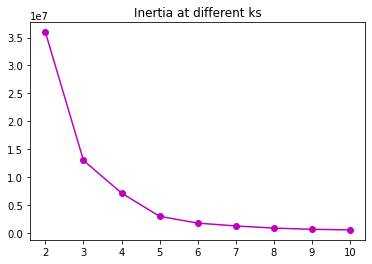

It seems like the best k is 9.


In [174]:
best_k = return_best_k(X)

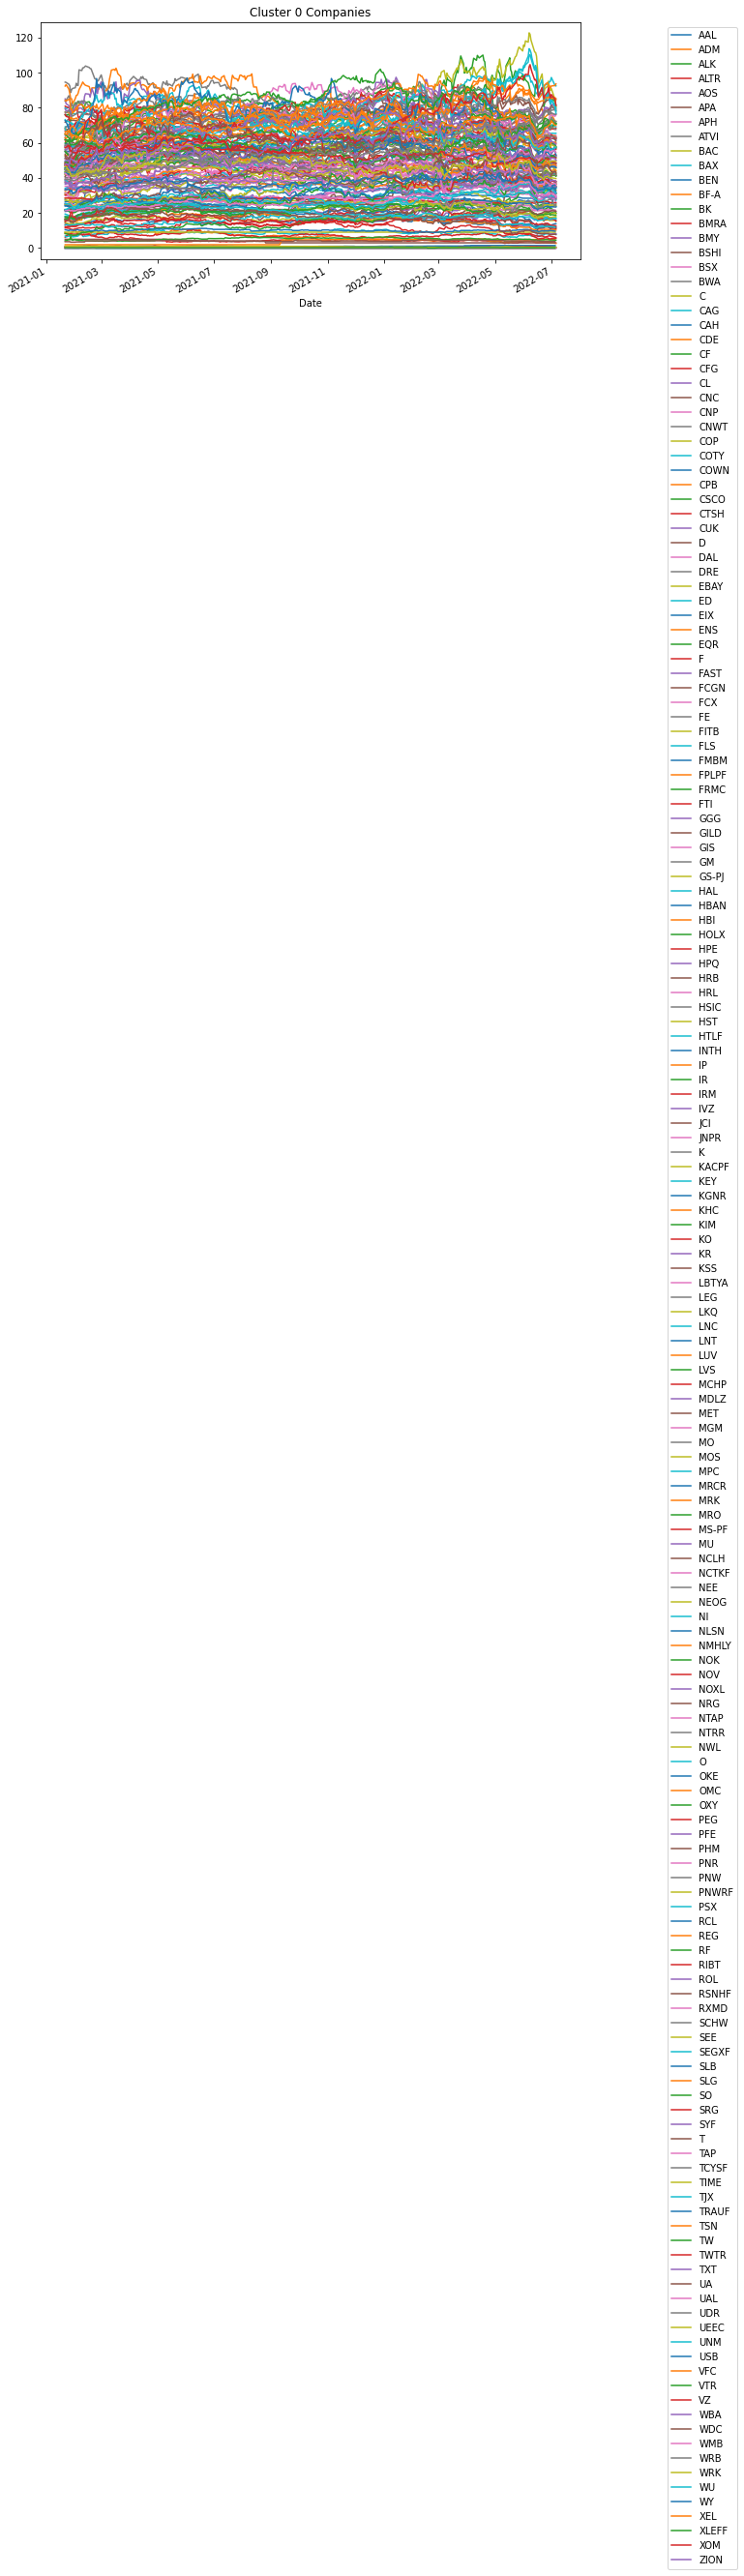

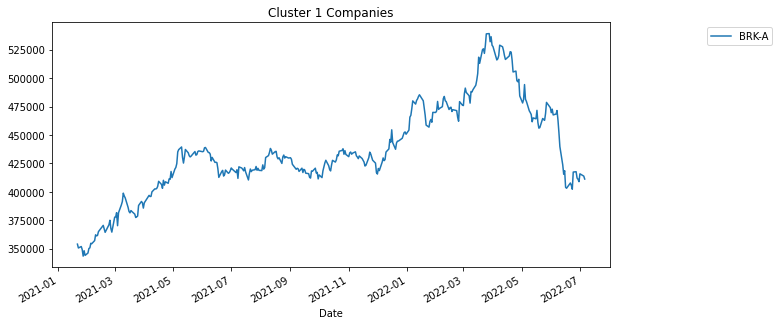

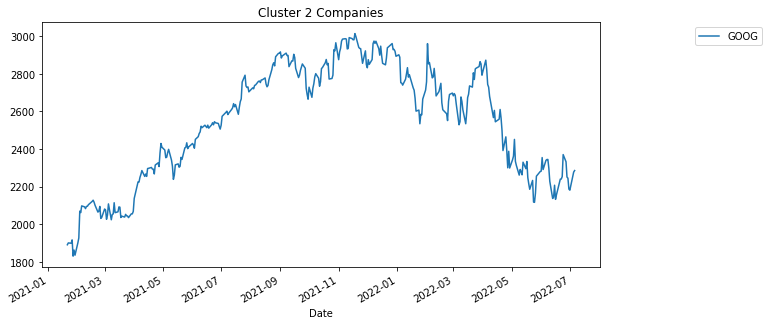

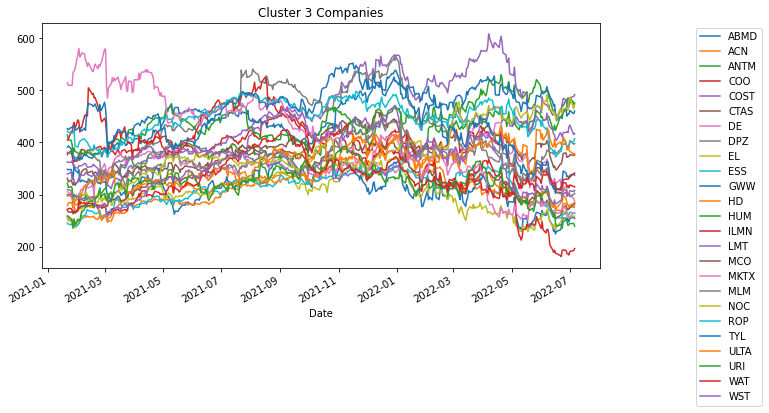

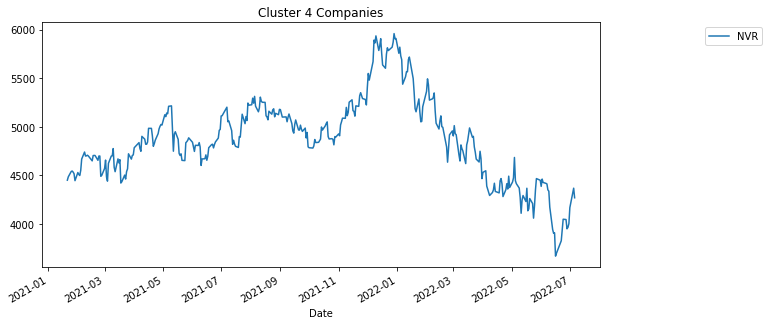

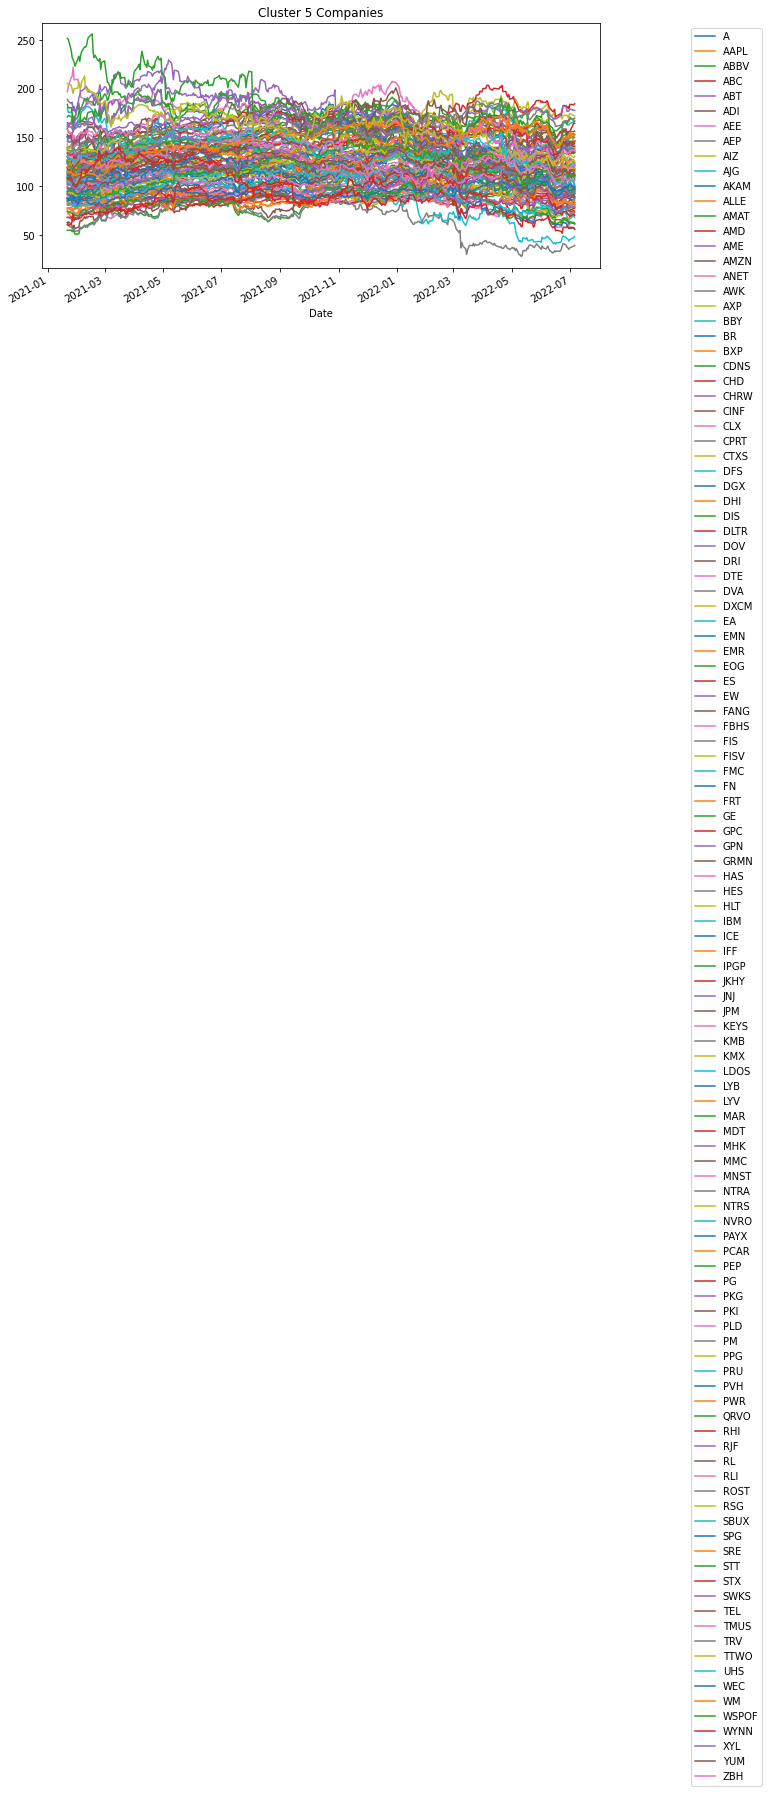

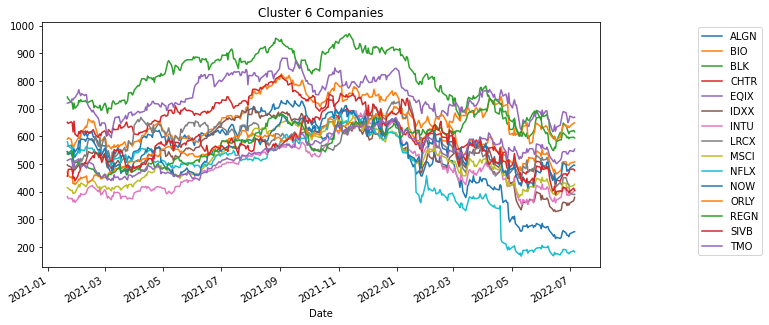

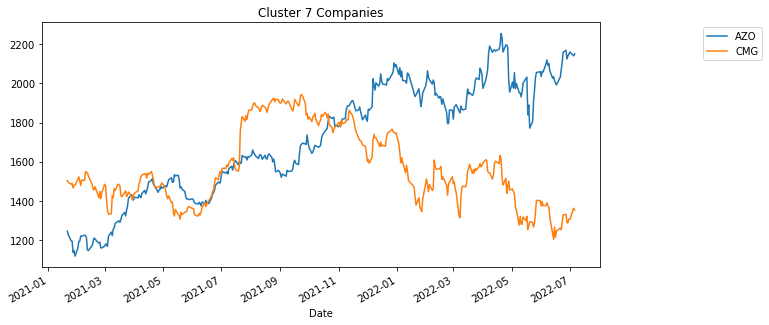

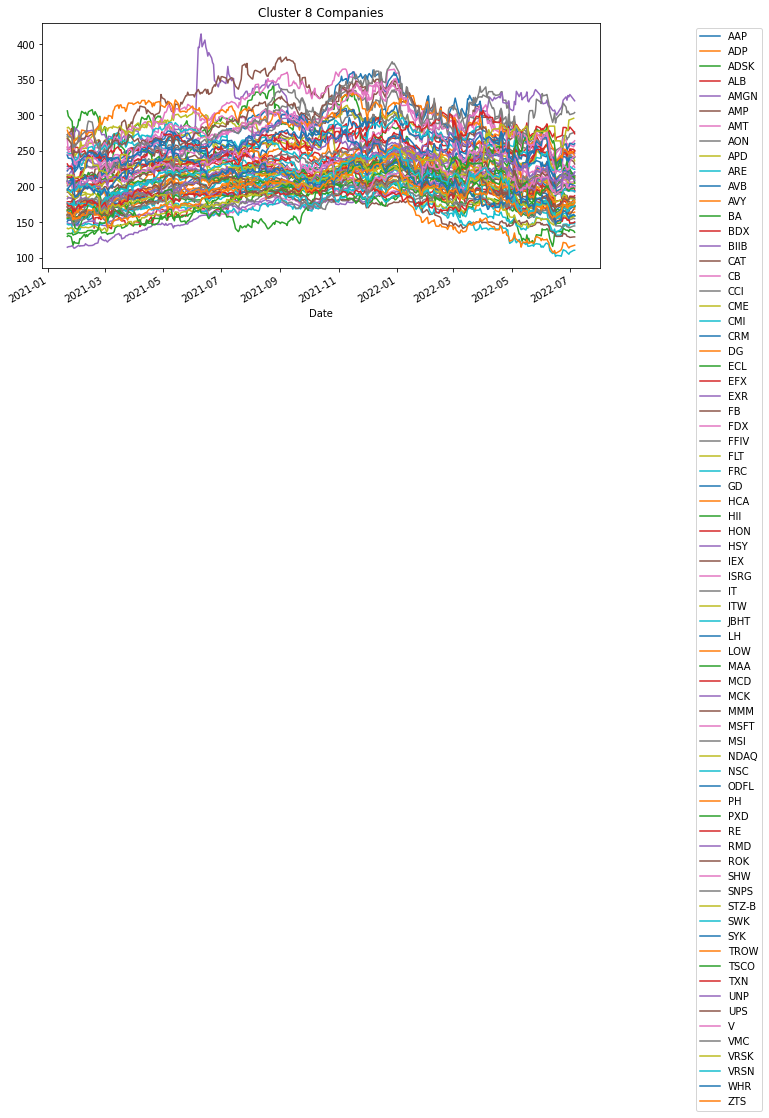

In [175]:
k = best_k
model = TSKM(n_clusters=k, n_init=3, metric = 'euclidean')
labels = model.fit_predict(X)
pivot_table['cluster_label_by_price'] = labels

for i in range(k):
    cluster_X_df = pivot_table[pivot_table['cluster_label_by_price'] == i]
    cluster_X_df = cluster_X_df.set_index('Symbol').iloc[:,:-1]

    cluster_X_df.T.plot(figsize=(10,5))
    plt.legend(bbox_to_anchor=(1.3, 1))
    plt.title('Cluster {} Companies'.format(i))

plt.show()

### Option 2: clustering on the percentage change of stock prices

In [176]:
X_pct = good_prices_pct.values

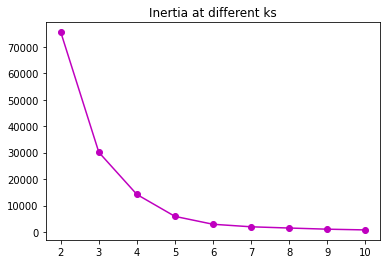

It seems like the best k is 10.


In [177]:
best_k = return_best_k(X_pct)

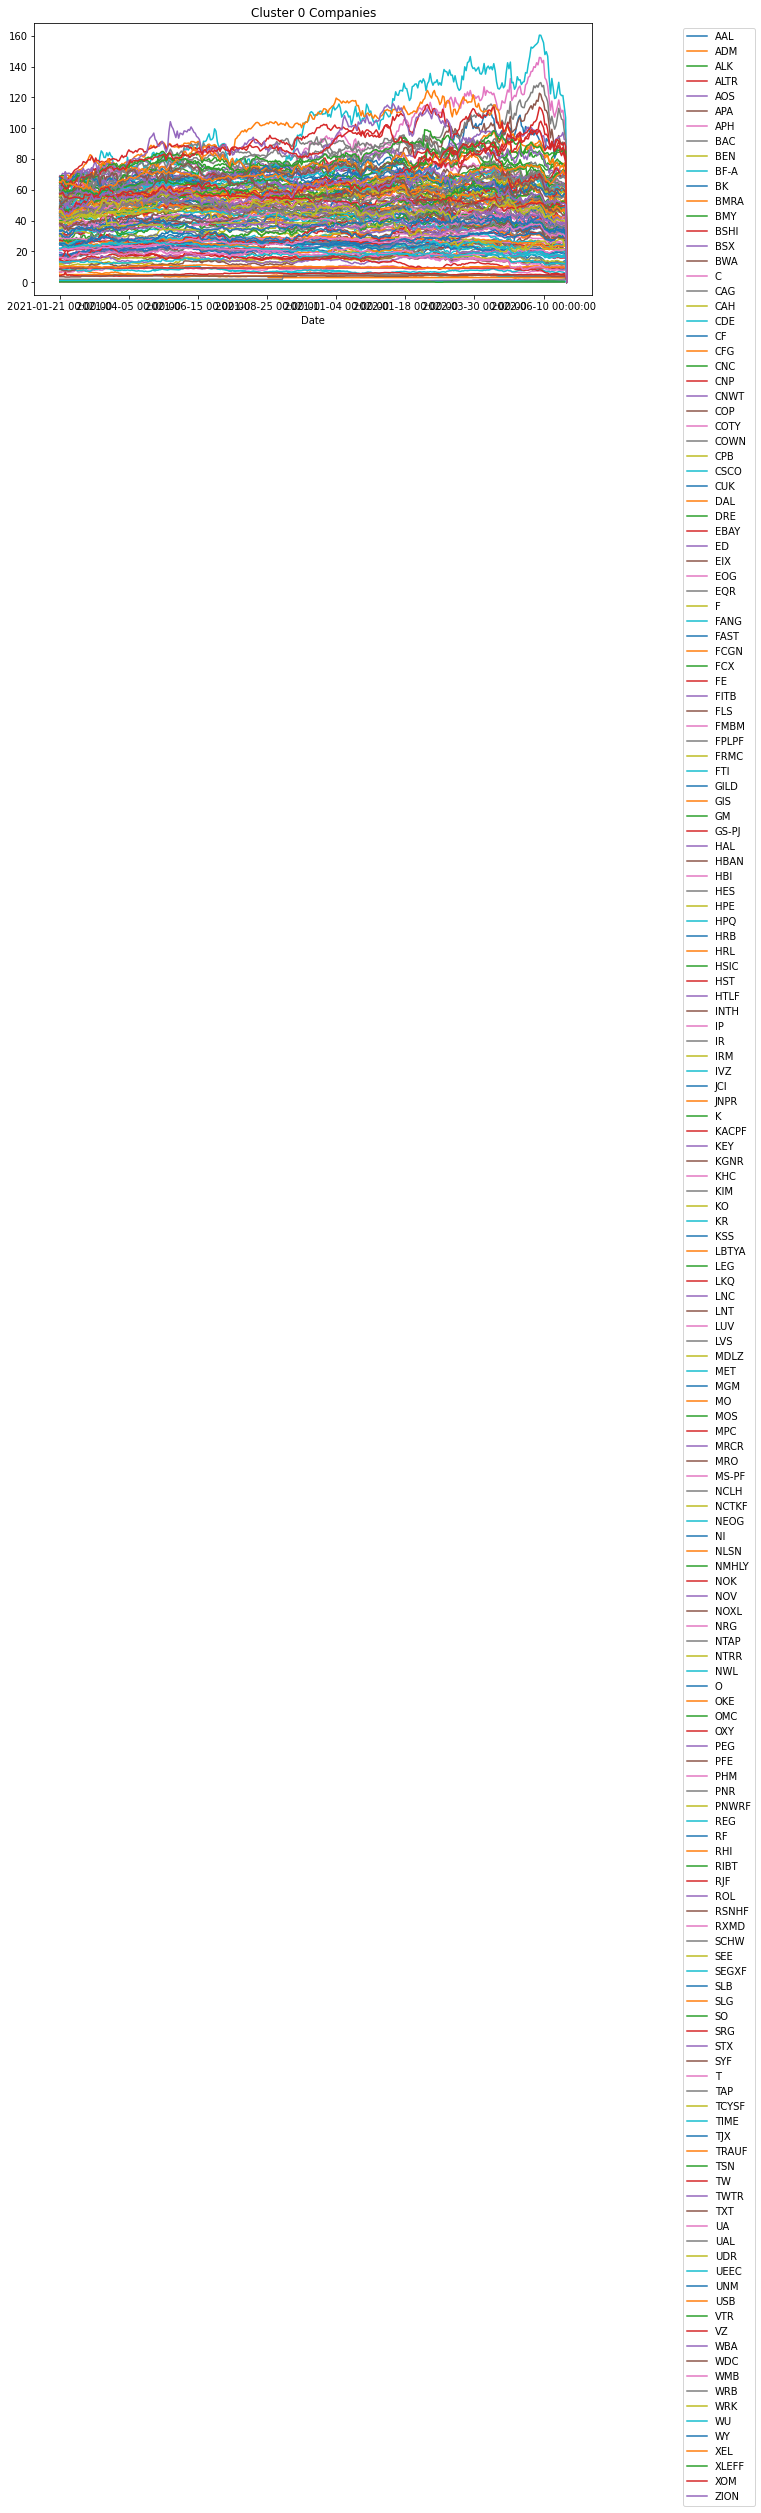

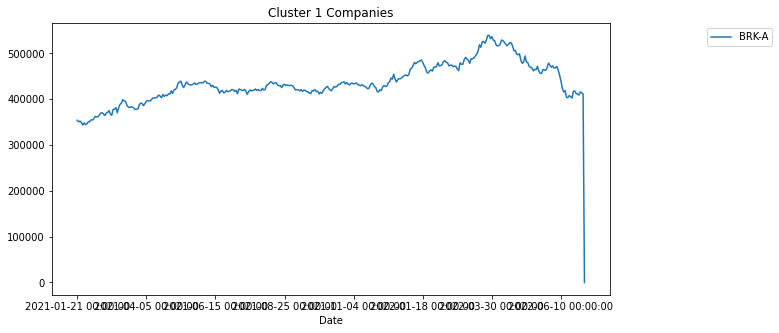

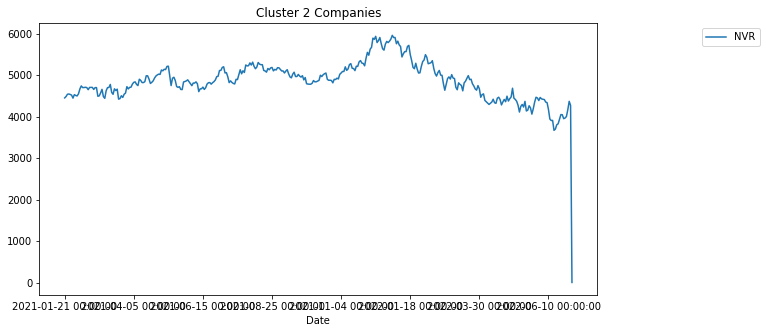

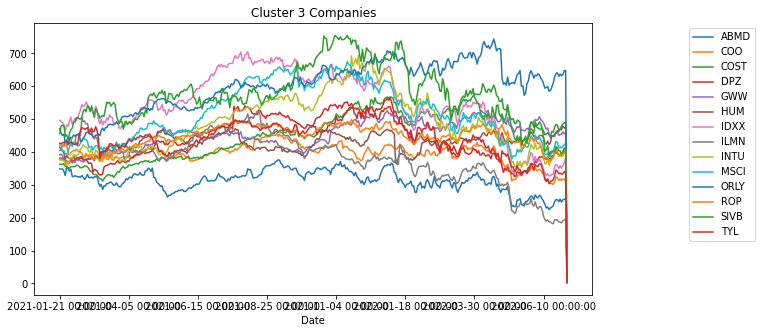

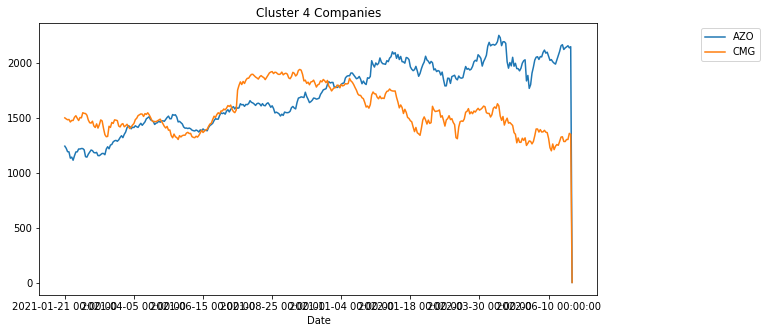

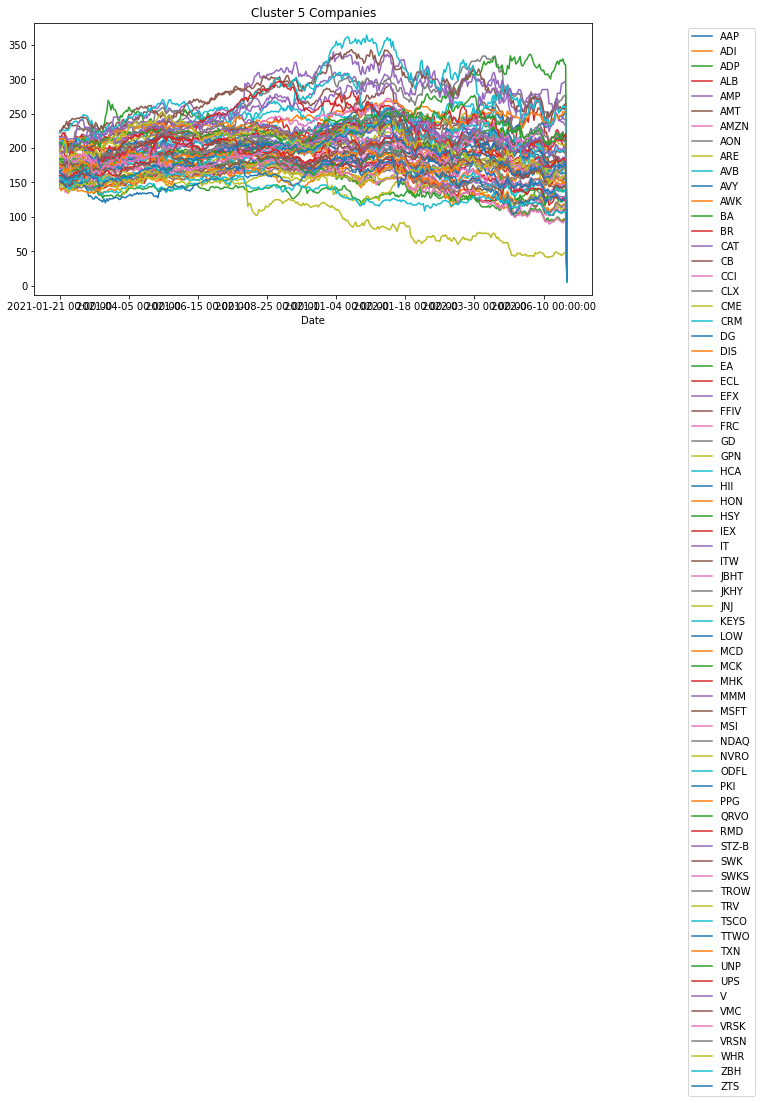

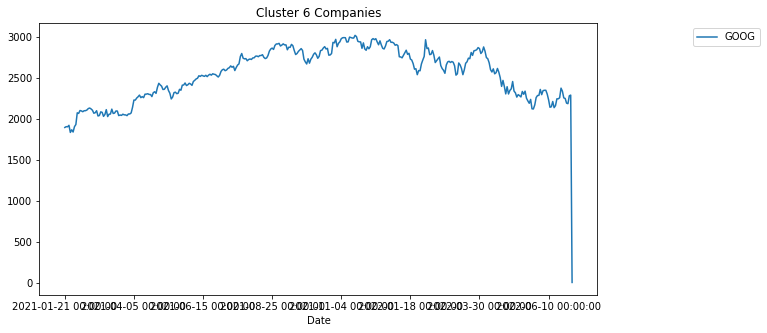

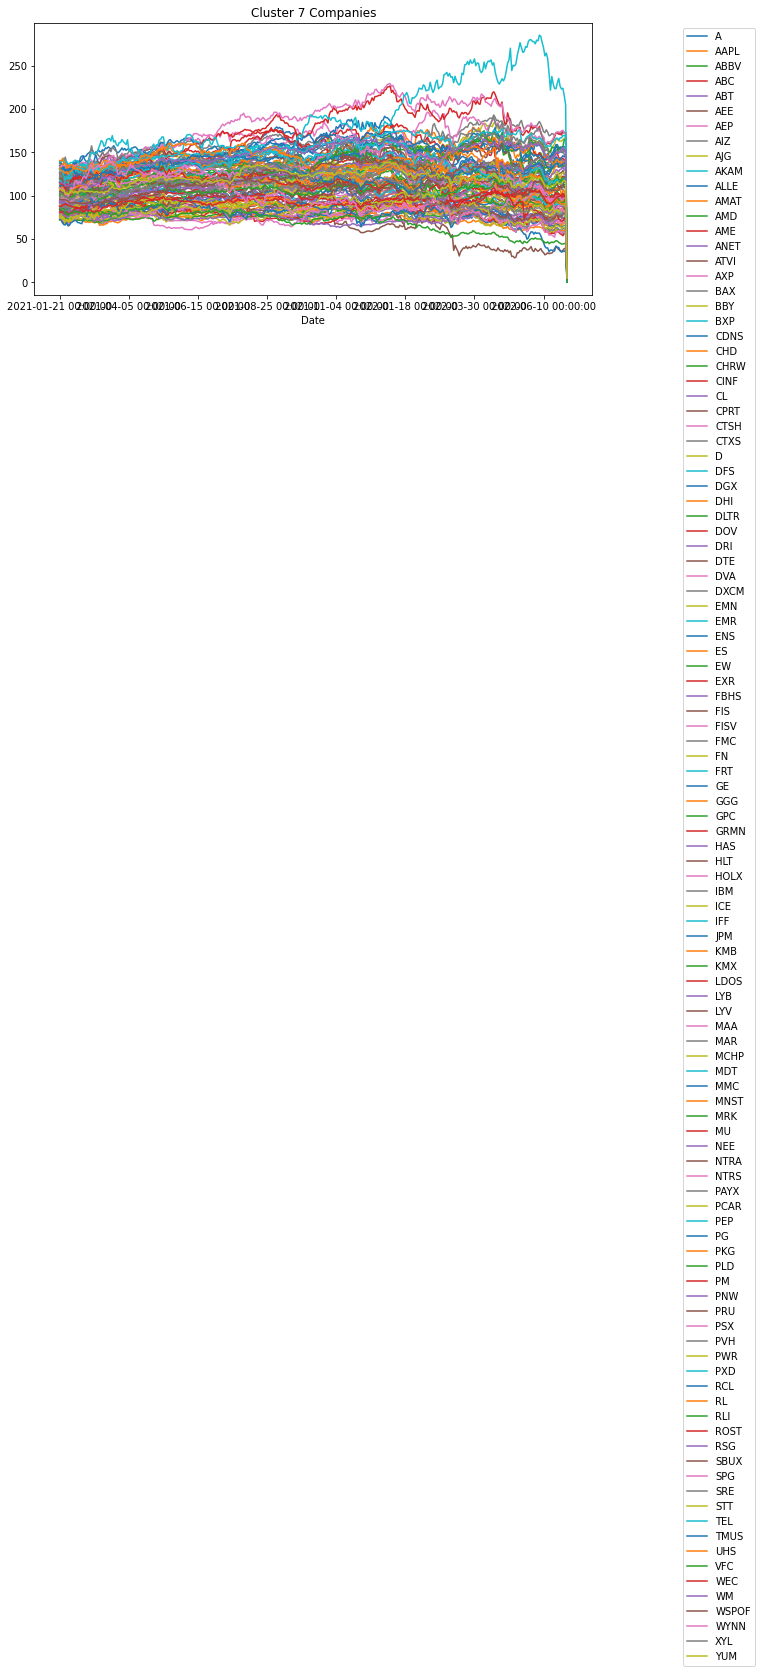

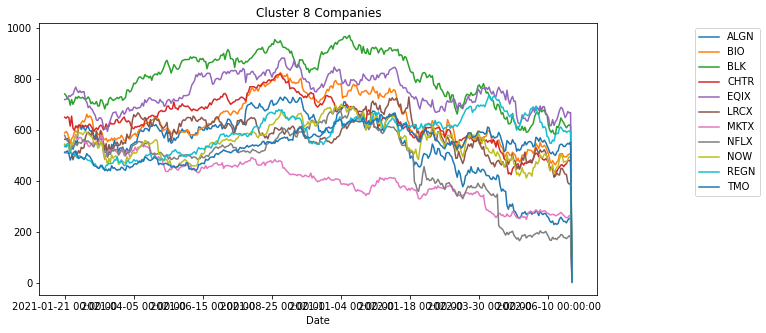

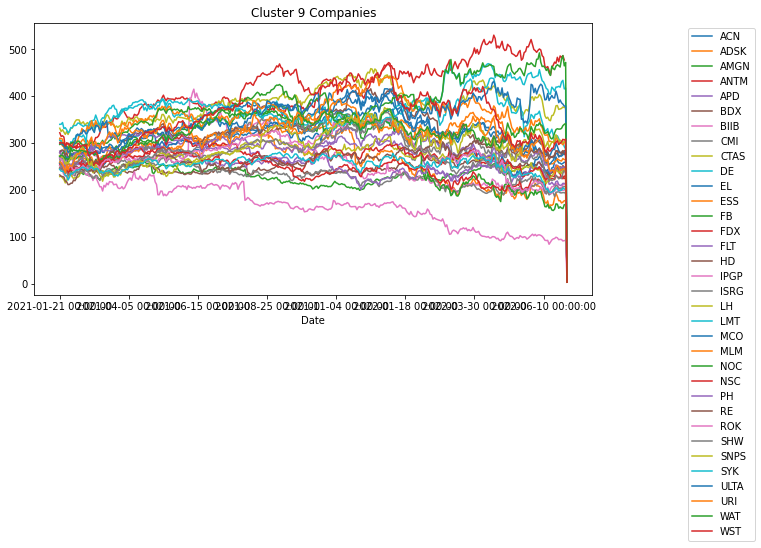

In [178]:
k = best_k
model = TSKM(n_clusters=k, n_init=3, metric = 'euclidean')
labels = model.fit_predict(X_pct)
pivot_table['cluster_label_by_pct'] = labels

for i in range(k):
    cluster_X_df = pivot_table[pivot_table['cluster_label_by_pct'] == i]
    cluster_X_df = cluster_X_df.set_index('Symbol').iloc[:,:-1]

    cluster_X_df.T.plot(figsize=(10,5))
    plt.legend(bbox_to_anchor=(1.3, 1))
    plt.title('Cluster {} Companies'.format(i))

plt.show()

### Outputting the labeled dataframe

In [179]:
pivot_table.to_csv('companies_clustered.csv')